In [1]:
from utils import *
import episcanpy.api as epi
import time
import umap

2024-03-02 13:08:37.064384: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-02 13:08:37.086387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-02 13:08:37.390610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Read data

In [2]:
file_path = '../data/E13_5-S1_atac.h5ad'

adata_raw = sc.read_h5ad(file_path)
adata_raw.obs['label'] = adata_raw.obs['Annotation_for_Combined']
print('load data: ', adata_raw)

epi.pp.filter_features(adata_raw, min_cells=1)
epi.pp.filter_cells(adata_raw, min_features=1)
num_all_peak = adata_raw.n_vars
print('data after pre-filtering: ', adata_raw)

load data:  AnnData object with n_obs × n_vars = 1777 × 271126
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes

# Run Descartes

In [3]:
save_path = '../result/mouse_brain'
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_select_peak = 10000
seed_base = 1
tf = 'tfidf2'
pc = 10
k = 20
similarity = 'cosine'
iter_time = 4
spmethod = 'threshold'
neighbor = 5
sp_dist = 'recip'
pre_select = 'highest'
peaks_num = 50000
distance = 'euclidean'
r = 0.4

start_time = time.time()

adata = sc.AnnData(adata_raw.X,dtype = 'float32')
idx, sorted_index, simi_matrix, idx_all, scores, selected_peaks_data,similarity_matrix_acb, similarity_matrix_spatial = run_descartes(adata_raw, num_select_peak, seed_base=seed_base, tfidf=tf, ifPCA=True, pc=pc, k=k, similarity=similarity, iters=iter_time, spmethod=spmethod,neighbor=neighbor,sp_dist=sp_dist, pre_select=pre_select, peaks_num=peaks_num, distance=distance,r=r)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time:.6f} seconds")

AnnData object with n_obs × n_vars = 1777 × 271126
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_Mito

# Peak module identification

In [4]:
start_time = time.time()
pdist_ = peak_modules_(selected_peaks_data=selected_peaks_data, similarity_matrix=simi_matrix, method='complete')
pdist_ = (pdist_+pdist_.T)/2
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time:.6f} seconds")
print("Peak modules calculation has been done.")

pdist_.shape

Running time: 2.744377 seconds
Peak modules calculation has been done.


(10000, 10000)

In [5]:
non_diagonal_values = pdist_[np.triu_indices(pdist_.shape[0], k=1)]
peak_similarity = np.copy(pdist_)
thd = np.percentile(non_diagonal_values, 99.5)
peak_similarity[peak_similarity > thd] = thd
peak_distance = thd - peak_similarity
np.fill_diagonal(peak_distance, 0)
peak_distance

array([[    0.        ,  5467.32607645,  4656.58217091, ...,
        15622.65786035, 16038.94440328, 16396.17880856],
       [ 5467.32607645,     0.        ,  3955.57562243, ...,
        11773.19234895, 11909.45926563, 13170.93507692],
       [ 4656.58217091,  3955.57562243,     0.        , ...,
        10698.74490126, 11046.46065148, 12415.61032444],
       ...,
       [15622.65786035, 11773.19234895, 10698.74490126, ...,
            0.        ,     0.        ,     0.        ],
       [16038.94440328, 11909.45926563, 11046.46065148, ...,
            0.        ,     0.        ,     0.        ],
       [16396.17880856, 13170.93507692, 12415.61032444, ...,
            0.        ,     0.        ,     0.        ]])

Cluster labels: [6 4 6 ... 1 1 1]


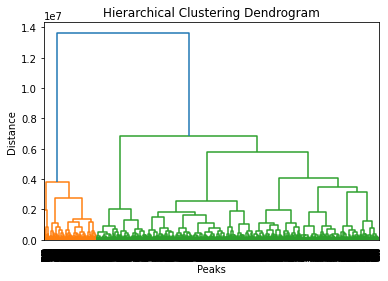

Number 1: Count = 153, Proportion = 1.53%
Number 2: Count = 1410, Proportion = 14.10%
Number 3: Count = 1522, Proportion = 15.22%
Number 4: Count = 3160, Proportion = 31.60%
Number 5: Count = 1416, Proportion = 14.16%
Number 6: Count = 1187, Proportion = 11.87%
Number 7: Count = 587, Proportion = 5.87%
Number 8: Count = 565, Proportion = 5.65%


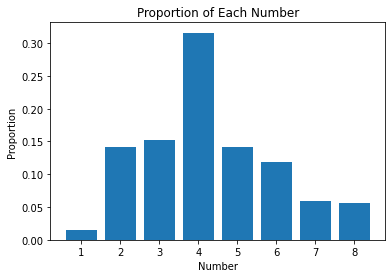

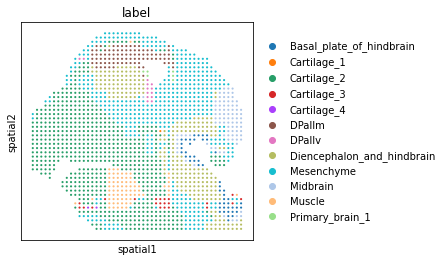

Number of peaks in module 1: 153
Visualize peak module of label 1:
9999


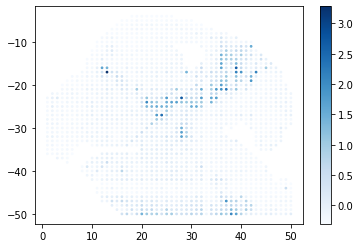

Number of peaks in module 2: 1410
Visualize peak module of label 2:
9999


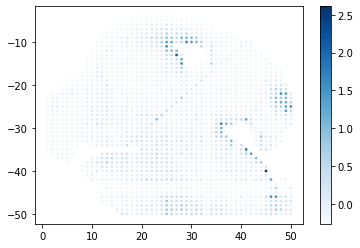

Number of peaks in module 3: 1522
Visualize peak module of label 3:
9999


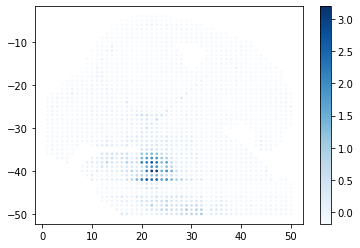

Number of peaks in module 4: 3160
Visualize peak module of label 4:
9999


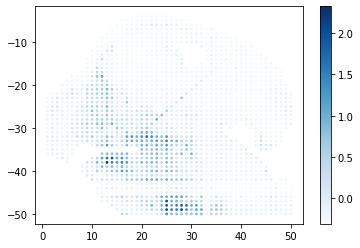

Number of peaks in module 5: 1416
Visualize peak module of label 5:
9999


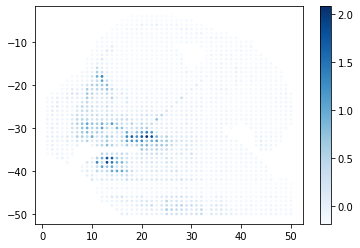

Number of peaks in module 6: 1187
Visualize peak module of label 6:
9999


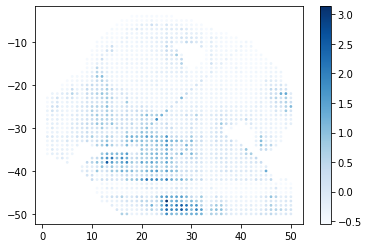

Number of peaks in module 7: 587
Visualize peak module of label 7:
9999


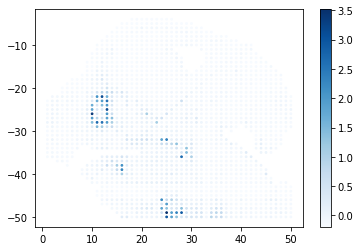

Number of peaks in module 8: 565
Visualize peak module of label 8:
9999


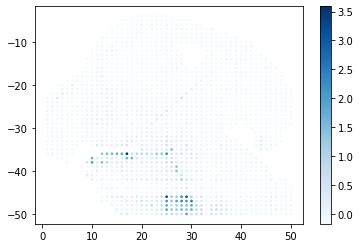

In [6]:
Z,labels = peak_module_cluster(adata_raw,idx,peak_distance,"ward",num_clusters = 8)

In [7]:
labels_temp = labels.copy()
labels_temp[labels == 4] = 9
labels_temp[labels == 5] = 4
labels_temp[labels == 6] = 5
labels_temp[labels == 7] = 6
labels_temp[labels == 8] = 7
labels_temp[labels == 4] = 8
labels = labels_temp

In [9]:
sparse_matrix = scipy.sparse.csr_matrix(adata_raw.X)
adata_temp = anndata.AnnData(X=sparse_matrix)
adata_temp.obs['label'] = list(adata_raw.obs['Annotation_for_Combined'])
adata_temp.var_names = adata_raw.var_names
label = np.array(adata_temp.obs['label'])
label[np.where(label == 'Cartilage_1')[0]] = 'Cartilage_2'
adata_temp.obs['label'] = label
adata_temp.X = sc.pp.log1p(adata_temp.X)
adata_temp.raw = adata_temp
epi.tl.rank_features(adata_temp, 'label')

a = np.array(adata_temp.uns['rank_features_groups']['names'].tolist())
domains = list(adata_temp.uns['rank_features_groups']['names'].dtype.names)
c = pd.DataFrame(a,columns=domains)
d = []
for domain in domains:
    b = list(c[domain])
    d.append(list(adata_raw.var_names.get_indexer(b)))
d = pd.DataFrame(np.array(d).T,columns=domains)
c, d


    			When the parameters where not specified in input


(    Basal_plate_of_hindbrain                Cartilage_2  \
 0       chr7:4123629-4124130   chr4:124708675-124709176   
 1     chr7:79525769-79526270    chr10:80260940-80261441   
 2   chr3:108433510-108434011     chr2:32317962-32318463   
 3   chr2:150643943-150644444    chr17:39843120-39843621   
 4     chr6:91301763-91302264   chr9:106356245-106356746   
 ..                       ...                        ...   
 95  chr8:124284228-124284729    chr11:74832081-74832582   
 96  chr4:154948216-154948717   chr7:113513425-113513926   
 97      chr1:5023194-5023695     chr5:34187588-34188089   
 98    chr1:34583718-34584219  chr11:109011651-109012152   
 99  chr4:140658105-140658606      chr19:8966769-8967270   
 
                   Cartilage_3               Cartilage_4  \
 0      chr2:33977596-33978097    chr7:37496483-37496984   
 1     chr11:38060130-38060631   chr16:77754716-77755217   
 2    chr2:172844886-172845387  chr5:135442428-135442929   
 3       chr16:8871329-8871830   chr15

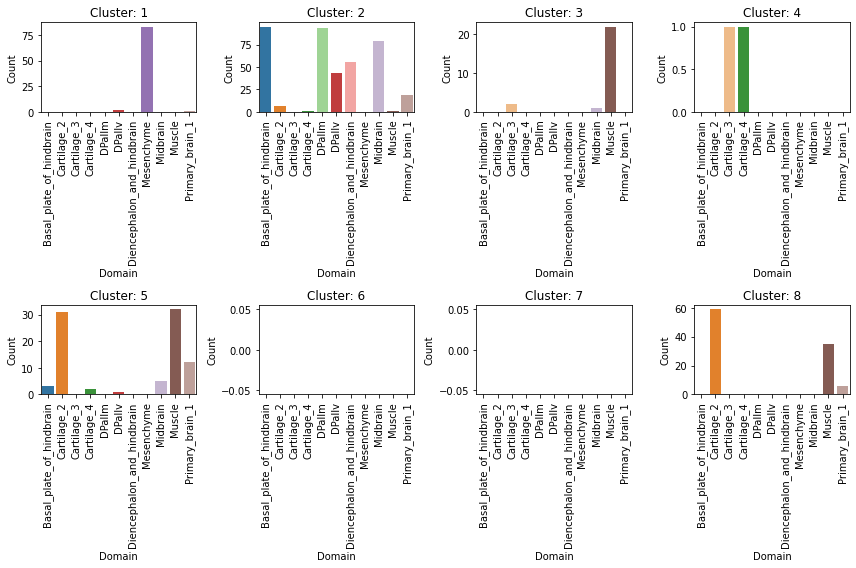

In [10]:
colors = ['#1f77b4', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94']
sns.set_palette(colors)

result = []
cluster = pd.DataFrame({'idx':idx, 'label':labels})
for i in np.unique(labels):
    data_new = cluster[cluster['label'] == i]
    idx_new = set(list(data_new['idx']))
    result_i = []
    for key in d.keys():
        idx_key = set(list(d[key]))
        result_i.append(len(idx_key.intersection(idx_new)))
    result.append(result_i)
result = pd.DataFrame(np.array(result).T)
result.index = d.keys()
result.columns = ['1','2','3','4','5','6','7','8']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))

for i, cluster in enumerate(result.columns):
    row, col = divmod(i, 4)
    sns.barplot(x=result.index, y=result[cluster], ax=axes[row, col])
    axes[row, col].set_title(f'Cluster: {cluster}')
    axes[row, col].set_xticklabels(result.index, rotation=90)
    axes[row, col].set_xlabel('Domain')
    axes[row, col].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [11]:
from scipy.cluster.hierarchy import leaves_list

pdist_z = scale(pdist_)
pdist_z = (pdist_z + pdist_z.T) / 2
results_z = pd.DataFrame(pdist_z)

ii = leaves_list(Z)
results_z = results_z.iloc[ii, ii]

label_indexed = pd.DataFrame(results_z, index=range(len(labels)))

# 按照labels的顺序重新排列行
sorted_results_z = label_indexed.loc[np.argsort(labels), np.argsort(labels)]
sorted_results_z

,9999,9015,659,696,803,8727,922,8530,8500,8426,...,7750,2800,1409,7753,7754,7756,2803,1407,5586,1107
9999,14.476394,9.112882,7.882280,5.788968,6.655483,8.866765,5.747101,8.556184,9.521926,8.528422,...,-3.327355,-2.562170,-1.919966,-3.624630,-4.877162,-3.847049,-2.687430,-3.034716,-2.635041,-5.911748
9015,9.112882,5.338840,4.846087,4.059998,4.372894,5.672135,4.475859,5.415946,5.334111,5.383827,...,-1.211453,-0.634420,-0.506562,-1.731589,-1.957102,-1.493708,-0.794904,-1.267968,-0.767361,-2.504818
659,7.882280,4.846087,4.183275,4.026110,4.374305,5.099464,3.525071,5.302626,4.345610,4.272121,...,-0.889417,-0.655752,-0.453170,-1.299480,-1.491961,-1.378223,-0.663756,-0.862516,-0.824307,-1.682968
696,5.788968,4.059998,4.026110,3.629805,2.076052,3.961942,3.701911,4.580175,3.194832,3.874146,...,-0.421220,-0.355804,0.010335,-0.781744,-1.302176,-1.079573,0.024233,-0.335983,-0.278231,-1.410916
803,6.655483,4.372894,4.374305,2.076052,4.388102,4.426593,2.647228,3.991514,3.486962,3.586508,...,-0.606327,-0.597512,0.134288,-0.874709,-1.201111,0.045636,-0.540877,-0.976514,-0.541438,-1.375193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7756,-3.847049,-1.493708,-1.378223,-1.079573,0.045636,-1.519163,-0.931043,-1.659503,-1.767397,-1.293313,...,1.077144,0.301955,1.011468,1.270341,1.413224,1.919059,0.428250,0.332296,0.710505,0.829387
2803,-2.687430,-0.794904,-0.663756,0.024233,-0.540877,-0.851961,-0.255797,-0.641746,-0.905795,-0.631613,...,0.358730,0.173232,0.240999,0.703061,0.842940,0.428250,1.001953,1.207698,1.110694,0.415941
1407,-3.034716,-1.267968,-0.862516,-0.335983,-0.976514,-1.204705,-0.504641,-0.698915,-1.212753,-0.586566,...,0.431888,0.071182,-0.634265,-0.063136,0.632460,0.332296,1.207698,1.329655,1.439592,-0.146472
5586,-2.635041,-0.767361,-0.824307,-0.278231,-0.541438,-1.078232,-0.175150,-0.631425,-0.854573,-0.736653,...,0.761756,0.585333,-0.016958,0.622847,0.840657,0.710505,1.110694,1.439592,1.369947,0.154605


In [12]:
name_map = {}
next_mod = 1
for i in sorted_results_z.index:
    mod = labels[i]
    if mod in name_map:
        continue
    if mod == -1:
        continue
    else:
        name_map[int(mod)] = "Module {}".format(next_mod)
        next_mod = next_mod + 1
name_map[-1] = "Module 0"

name_map_r = {v: k for k, v in name_map.items()}
name_map, name_map_r

({1: 'Module 1',
  2: 'Module 2',
  3: 'Module 3',
  4: 'Module 4',
  5: 'Module 5',
  6: 'Module 6',
  7: 'Module 7',
  8: 'Module 8',
  -1: 'Module 0'},
 {'Module 1': 1,
  'Module 2': 2,
  'Module 3': 3,
  'Module 4': 4,
  'Module 5': 5,
  'Module 6': 6,
  'Module 7': 7,
  'Module 8': 8,
  'Module 0': -1})

In [13]:
colors = sns.color_palette("muted")
colormap = {i: colors[i % 10] if i != -1 else (1.0, 1.0, 1.0) for i in np.unique(labels)}
colormap_r = {v: k for k, v in colormap.items()}
row_colors1 = pd.Series(
    [colormap[i] for i in labels],
    index=range(10000),
)

row_colors = pd.DataFrame({"Module": row_colors1})
row_colors = row_colors.loc[sorted_results_z.index]

cmap = sns.diverging_palette(230, 20, sep=20, s=85, l=50, as_cmap=True)

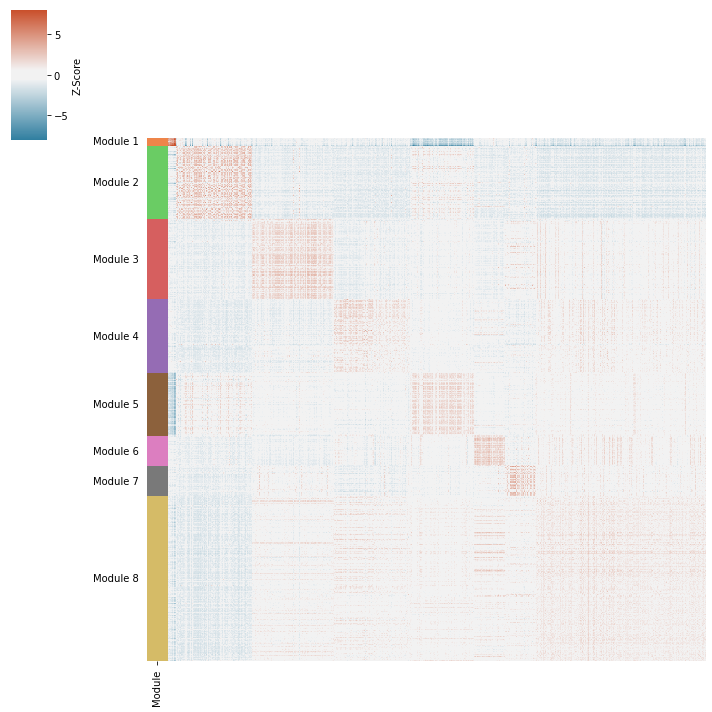

In [14]:
cm = sns.clustermap(
    sorted_results_z,
    row_cluster=False,
    col_cluster=False,
    vmin=-8,
    vmax=8,
    cmap=cmap,
    xticklabels=False,
    yticklabels=False,
    row_colors=row_colors,
    rasterized=True,
    cbar_kws=dict(
        label="Z-Score",
#         ticks=[-8, 0, 8],
    ),
)

fig = plt.gcf()
fig.patch.set_visible(False)
plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("")

# Assuming row_colors is ordered, label the groups
plt.sca(cm.ax_row_colors)
for i in row_colors.Module.unique():
    if i == (1.0, 1.0, 1.0):
        continue
    mid = 0
    count = 0
    cl = colormap_r[i]
    for j, x in enumerate(row_colors.Module.values):
        if x == i:
            mid += j
            count += 1

    mid = mid/count

    plt.text(-.4, mid, name_map[cl],
             horizontalalignment='right',
             verticalalignment='center')

plt.show()